In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%autosave 20

Autosaving every 20 seconds


In [2]:
import pandas as pd
import numpy as np

from geopy.geocoders import Nominatim
from math import radians, cos, sin, asin, sqrt 
import folium

import matplotlib.pyplot as plt
import seaborn as sns

from deap import algorithms, base, creator, tools


### Reading the Location File

In [3]:
df_loc = pd.read_csv('Final_location_data.csv')

In [4]:
df_loc = df_loc[df_loc.State == 'Karnataka']

In [5]:
df_loc.drop_duplicates('place',inplace = True)
df_loc.reset_index(drop = True,inplace = True)

### Making the Ratings based on Number of ratings given and Rating overall

In [6]:
df_loc['Rating'] = (df_loc.Popularity/df_loc.Popularity.max()) *df_loc.Rating

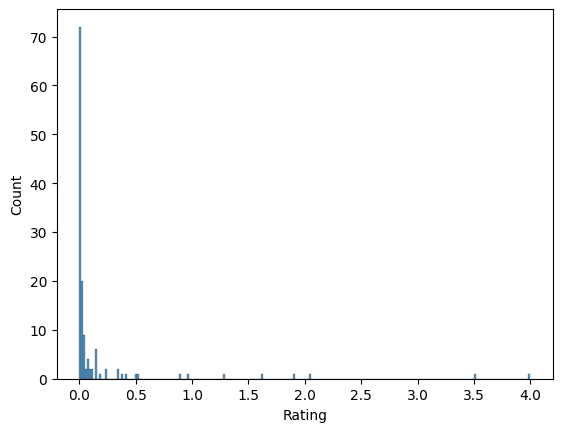

In [7]:
_ = sns.histplot(df_loc.Rating)

In [8]:
df_loc.sample(5)

,place,Rating,Popularity,latitude,longitude,State
59,Dharmaraya Swamy Temple,0.016801,26.0,12.965521,77.583187,Karnataka
34,Sri Someshwara Swamy Temple,0.045800,63.0,12.969466,77.579482,Karnataka
107,Safina Plaza,0.009693,15.0,12.979697,77.606794,Karnataka
63,Sri Ranganatha Swamy Temple,0.006543,9.0,12.425079,76.679295,Karnataka
30,Kynkyny Art,0.023263,32.0,12.983394,77.593893,Karnataka


In [9]:
MAP = folium.Map(location=[np.mean(df_loc.latitude), np.mean(df_loc.longitude)], zoom_start=5, tiles='Stamen Toner')
for index, row in df_loc.iterrows():
    popup_txt = "%s // Score : %s " % (row.place, row.Rating)
    folium.Marker([row.latitude, row.longitude], popup=popup_txt).add_to(MAP)

In [10]:
MAP

# Genetic Algo tool

### Creator

In [11]:
creator.create("FitnessMulti", base.Fitness, weights=(-1.0,1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

### Toolbox

In [12]:
toolbox = base.Toolbox()

In [13]:
# Attribute generator 
N_place= 7
toolbox.register("index", np.random.choice, len(df_loc), N_place, replace=False) # choose 5 spots

In [14]:
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.index)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [15]:
ind = toolbox.individual()
ind

[90, 48, 39, 79, 44, 114, 1]

### The Evaluation Function
objective function 1. total distance -> minimun  & 
objective function 2. total score -> maximum

In [16]:
def create_tour(individual):
    return [(df_loc.iloc[i].latitude, df_loc.iloc[i].longitude) for i in individual]

In [17]:
tour = create_tour(ind)
tour

[(12.3249513, 76.6271025),
 (12.93566795, 77.5176769193037),
 (12.9078462, 77.60113103400322),
 (12.9433162, 77.70004387539987),
 (12.9069355, 77.61352381609713),
 (12.9508248, 77.6236033),
 (12.9489367, 77.58698687897964)]

In [18]:
## Function for get a total distance of tour case
def total_distance(tour):
    tour_sum = sum(distance(tour[i], tour[i+1]) for i in range(len(tour)-1))
    return tour_sum

def distance(spot1, spot2):
    # convert decimal degrees to radians 
    lng1, lat1, lng2, lat2 = map(radians, [spot1[0], spot1[1], spot2[0], spot2[1]])
    
    RADIUS = 6371 # FAA approved globe radius in km
    
    dlng = lng2-lng1
    dlat = lat2-lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    c = 2 * asin(sqrt(a)) 
    dist = RADIUS * c
    return dist

### Calculating total Distance

In [19]:
total_distance(tour)

135.7836387472092

### Ploting the Tour

In [20]:
def plot_tour(ind):
    tour = create_tour(ind)
    m = folium.Map(location=[np.mean(df_loc.latitude), np.mean(df_loc.longitude)], zoom_start=8)
    path=folium.PolyLine(locations=tour,weight=5)
    m.add_children(path)
    for i,loc in enumerate(ind):
        popup_txt = "%s // Score : %s " % (df_loc.iloc[loc].place, df_loc.iloc[loc].Rating)
        folium.Marker(tour[i], popup=popup_txt).add_to(m)
    return m

In [21]:
plot_tour(ind)

/tmp/ipykernel_26978/2200379965.py:5: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  m.add_children(path)


### Scoring The Output 

In [22]:
def total_score(individual):
    return sum([df_loc.iloc[i]['Rating'] for i in individual]) 

In [23]:
total_score(ind)

4.111631663974152

In [24]:
def eval_func(individual):
    # 1 total distance -> minimun
    t_dist = total_distance(create_tour(individual))
    # 2 total score -> maximum
    t_score = total_score(individual)
    # 3 penalty
    penalty = len(individual) - len(set(individual))
    t_dist += penalty*1000000
    t_score -= penalty*1000000
    return t_dist, t_score

In [25]:
eval_func(ind)

(135.7836387472092, 4.111631663974152)

### Genetic OIperators

In [26]:
toolbox.register("evaluate", eval_func)

In [27]:
toolbox.register("select", tools.selNSGA2)
toolbox.register("mate", tools.cxTwoPoint)
# tools.mutShuffleIndexes : Shuffle the attributes of the input individual and return the mutant.
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.8) 

In [28]:
POP_SIZE = 200
MAX_GEN = 100
MUT_PROB = 0.2
CX_PROB = 0.8

In [29]:
pop = toolbox.population(n=POP_SIZE)
pop

[[16, 55, 13, 78, 118, 87, 115],
 [42, 45, 90, 64, 102, 109, 87],
 [108, 79, 119, 106, 62, 97, 91],
 [20, 29, 122, 67, 41, 6, 31],
 [82, 59, 3, 95, 28, 130, 24],
 [54, 120, 21, 90, 76, 16, 133],
 [125, 61, 73, 78, 17, 9, 0],
 [18, 43, 59, 99, 10, 110, 112],
 [127, 29, 64, 131, 38, 60, 56],
 [28, 50, 90, 51, 69, 97, 116],
 [1, 85, 72, 86, 40, 124, 19],
 [125, 127, 87, 85, 58, 66, 12],
 [96, 5, 27, 110, 129, 80, 86],
 [24, 44, 72, 46, 36, 38, 55],
 [56, 16, 69, 0, 128, 88, 109],
 [29, 107, 58, 6, 1, 11, 77],
 [121, 131, 32, 30, 96, 28, 104],
 [61, 67, 13, 12, 25, 97, 130],
 [12, 101, 8, 72, 36, 66, 81],
 [45, 65, 79, 43, 116, 75, 94],
 [2, 64, 117, 9, 101, 77, 109],
 [19, 127, 31, 112, 10, 30, 38],
 [12, 26, 22, 16, 30, 65, 25],
 [114, 37, 36, 119, 40, 131, 89],
 [32, 127, 48, 69, 55, 129, 98],
 [114, 77, 55, 92, 30, 97, 7],
 [61, 115, 76, 64, 91, 125, 45],
 [74, 94, 133, 118, 66, 88, 71],
 [78, 101, 92, 15, 116, 75, 124],
 [63, 82, 13, 91, 25, 120, 14],
 [15, 130, 52, 120, 70, 123, 67],

In [30]:
hof = tools.ParetoFront()

In [31]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0) 
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

In [32]:
%%time 
result, log = algorithms.eaMuPlusLambda(pop, 
                                     toolbox, 
                                     mu=POP_SIZE, # The number of individuals to select for the next generation.
                                     lambda_= POP_SIZE, # The number of children to produce at each generation.
                                     cxpb= CX_PROB,
                                     mutpb= MUT_PROB, 
                                     stats= stats, 
                                     ngen= MAX_GEN,
                                     verbose= True,
                                       halloffame=hof)

gen	nevals	avg                        	min                      	max                        
0  	200   	[153.2116924    1.19685985]	[16.68056094  0.04846527]	[843.55118052   6.65436187]
1  	200   	[106.10765662   2.00830977]	[15.38737793  0.04846527]	[843.55118052   6.65436187]
2  	200   	[97.76285533  2.74922536]  	[10.9405396   0.05961228]	[843.55118052   6.65436187]
3  	200   	[72.95315606  3.52607027]  	[10.9405396   0.05961228]	[843.71301546   7.67189015]
4  	200   	[55.77988412  3.87848586]  	[10.08237291  0.03699515]	[623.2856199    9.69434572]
5  	200   	[73.10841391  4.41916761]  	[6.68242906 0.03699515]  	[623.2856199    9.69434572]
6  	200   	[86.13335334  5.21716882]  	[6.68242906 0.05815832]  	[623.2856199    9.77358643]
7  	200   	[126.59495149   5.99535864]	[6.65667548 0.11171244]  	[623.2856199    9.77358643]
8  	200   	[167.83481248   6.57695396]	[6.65667548 0.19563813]  	[761.59926922  10.85234249]
9  	200   	[150.9030634   6.9039794]  	[6.59901675 0.23457189]  	[623.

In [33]:
hof.items[0]

[5, 119, 2, 4, 35, 20, 7]

In [34]:
fronts = tools.emo.sortLogNondominated(result, len(result))

In [35]:
fronts[0][0]

[5, 119, 2, 4, 35, 20, 7]

In [36]:
df_loc.iloc[hof.items[0]]

,place,Rating,Popularity,latitude,longitude,State
5,Visvesvaraya Industrial and Technological Museum,1.283845,1766.0,12.975284,77.596284,Karnataka
119,Museum of Art and Photography,0.000808,1.0,12.974507,77.596808,Karnataka
2,UB City,2.036995,2802.0,12.972334,77.596114,Karnataka
4,Cubbon Park,1.613570,2497.0,12.974244,77.592195,Karnataka
35,Karnataka High Court,0.080129,124.0,12.977885,77.592673,Karnataka
20,Indira Gandhi Musical Fountain,0.149919,232.0,12.985200,77.591859,Karnataka
7,Bangalore Palace,0.961793,1701.0,12.998595,77.592009,Karnataka


In [37]:
df_loc.iloc[fronts[0][0]]

,place,Rating,Popularity,latitude,longitude,State
5,Visvesvaraya Industrial and Technological Museum,1.283845,1766.0,12.975284,77.596284,Karnataka
119,Museum of Art and Photography,0.000808,1.0,12.974507,77.596808,Karnataka
2,UB City,2.036995,2802.0,12.972334,77.596114,Karnataka
4,Cubbon Park,1.613570,2497.0,12.974244,77.592195,Karnataka
35,Karnataka High Court,0.080129,124.0,12.977885,77.592673,Karnataka
20,Indira Gandhi Musical Fountain,0.149919,232.0,12.985200,77.591859,Karnataka
7,Bangalore Palace,0.961793,1701.0,12.998595,77.592009,Karnataka


In [38]:
df_loc.iloc[fronts[0][99]]

,place,Rating,Popularity,latitude,longitude,State
5,Visvesvaraya Industrial and Technological Museum,1.283845,1766.0,12.975284,77.596284,Karnataka
119,Museum of Art and Photography,0.000808,1.0,12.974507,77.596808,Karnataka
2,UB City,2.036995,2802.0,12.972334,77.596114,Karnataka
115,Bengaluru Lights,0.004039,5.0,12.965254,77.595615,Karnataka
35,Karnataka High Court,0.080129,124.0,12.977885,77.592673,Karnataka
4,Cubbon Park,1.613570,2497.0,12.974244,77.592195,Karnataka
1,Lalbagh Botanical Garden,4.000000,6190.0,12.948937,77.586987,Karnataka


In [39]:
df_loc.iloc[hof[0]]

,place,Rating,Popularity,latitude,longitude,State
5,Visvesvaraya Industrial and Technological Museum,1.283845,1766.0,12.975284,77.596284,Karnataka
119,Museum of Art and Photography,0.000808,1.0,12.974507,77.596808,Karnataka
2,UB City,2.036995,2802.0,12.972334,77.596114,Karnataka
4,Cubbon Park,1.613570,2497.0,12.974244,77.592195,Karnataka
35,Karnataka High Court,0.080129,124.0,12.977885,77.592673,Karnataka
20,Indira Gandhi Musical Fountain,0.149919,232.0,12.985200,77.591859,Karnataka
7,Bangalore Palace,0.961793,1701.0,12.998595,77.592009,Karnataka


In [40]:
# Higher score but Longer distance
print(eval_func(fronts[0][99])) 
plot_tour(fronts[0][99])

(1.7164002554494562, 9.019386106623587)


/tmp/ipykernel_26978/2200379965.py:5: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  m.add_children(path)


In [41]:
# Shorter distance but Lower score
print(eval_func(fronts[0][0]))  
plot_tour(fronts[0][0])

(1.2114769647144255, 6.127059773828757)


/tmp/ipykernel_26978/2200379965.py:5: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  m.add_children(path)


In [42]:
best_individual = tools.selBest(pop, k=4)[0]

In [43]:
best_individual

[5, 119, 2, 4, 35, 20, 7]

In [44]:
df_loc.iloc[best_individual]

,place,Rating,Popularity,latitude,longitude,State
5,Visvesvaraya Industrial and Technological Museum,1.283845,1766.0,12.975284,77.596284,Karnataka
119,Museum of Art and Photography,0.000808,1.0,12.974507,77.596808,Karnataka
2,UB City,2.036995,2802.0,12.972334,77.596114,Karnataka
4,Cubbon Park,1.613570,2497.0,12.974244,77.592195,Karnataka
35,Karnataka High Court,0.080129,124.0,12.977885,77.592673,Karnataka
20,Indira Gandhi Musical Fountain,0.149919,232.0,12.985200,77.591859,Karnataka
7,Bangalore Palace,0.961793,1701.0,12.998595,77.592009,Karnataka
